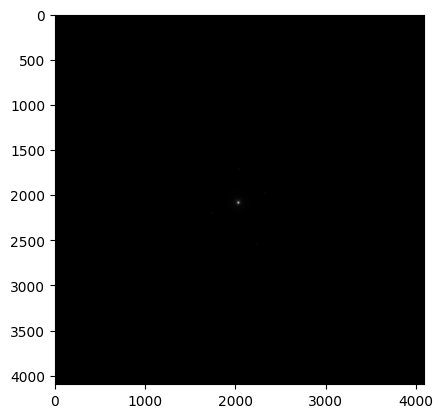

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from glob import glob

file_list = sorted(glob('../data/Sergi_data_monoclinic/BI-7273_Set2/BI-7273_set_2_dp_tif/*.tif'))
img = cv2.imread(file_list[0], cv2.IMREAD_UNCHANGED).astype(np.uint16)

plt.imshow(img, cmap='gray')


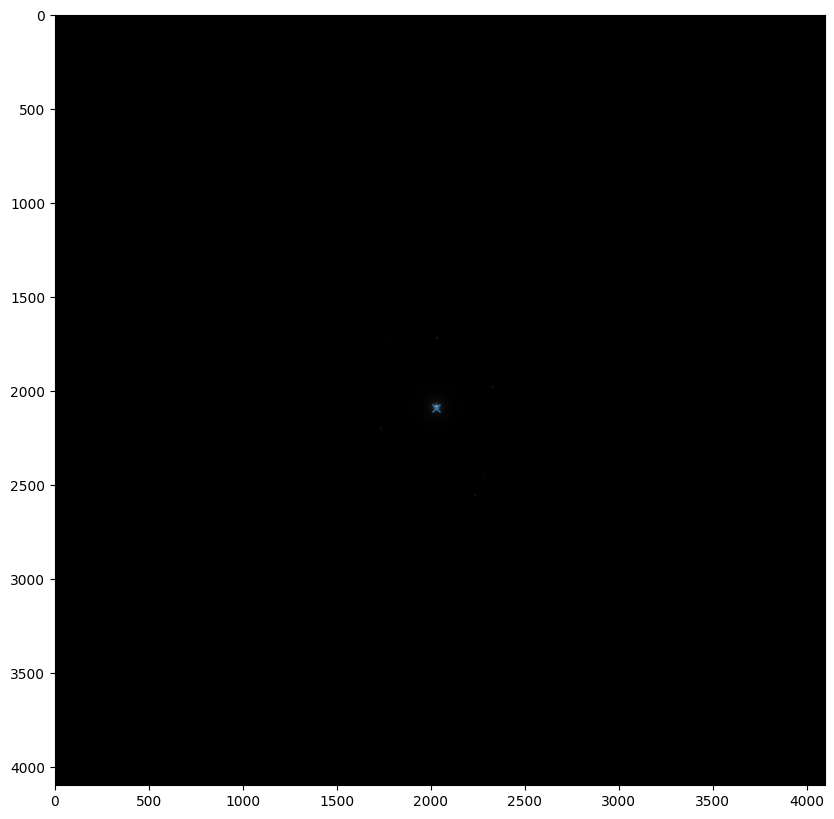

In [2]:
import numpy as np
from scipy.ndimage import maximum_filter, gaussian_filter
from scipy.interpolate import interp1d

def calculate_center_coordinate(img, sigma=10, search_size=40, neighborhood_size=20):
    filtered_image = gaussian_filter(img, sigma=sigma)
    center_ind = filtered_image.argmax()
    center_coor = np.array([center_ind % img.shape[0], center_ind // img.shape[0]])

    image, x, y = filtered_image, center_coor[0], center_coor[1]
    half_size = search_size // 2

    # Define search window boundaries with clipping at image edges
    x_min = max(x - half_size, 0)
    x_max = min(x + half_size + 1, image.shape[1])
    y_min = max(y - half_size, 0)
    y_max = min(y + half_size + 1, image.shape[0])

    # Extract the search region
    search_region = image[y_min:y_max, x_min:x_max]

    # Find local maxima in the search region using a maximum filter
    local_max = (search_region == maximum_filter(search_region, size=neighborhood_size))

    # Get coordinates of all local maxima in the search region
    max_coords = np.argwhere(local_max)

    if len(max_coords) == 0:
        # No local maxima found, return the original point and its value
        return (x, y), image[y, x]

    # Convert local max coordinates to global image coordinates
    global_coords = max_coords + np.array([y_min, x_min])

    # Calculate distances to (y, x)
    distances = np.sqrt((global_coords[:, 0] - y)**2 + (global_coords[:, 1] - x)**2)

    # Find the closest maximum
    closest_index = np.argmin(distances)
    closest_max_pos = (global_coords[closest_index, 1], global_coords[closest_index, 0])  # (x, y)
    closest_max_value = image[closest_max_pos[1], closest_max_pos[0]]
    return closest_max_pos, closest_max_value

img=cv2.imread(file_list[0], cv2.IMREAD_UNCHANGED).astype(np.uint16)
closest_max_pos, closest_max_value = calculate_center_coordinate(img, sigma=20, search_size=60, neighborhood_size=20)

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.plot(closest_max_pos[0], closest_max_pos[1], 'x')


In [3]:
def radial_profile(data, center=None, bins=100, reduce=np.median):
    """
    Compute radial profile of 2D data by integrating pixel values radially.

    Parameters:
        data : 2D numpy array
            Input image data (e.g., Gaussian bell).
        center : tuple or None
            (x, y) coordinates of the center. If None, uses image center.
        bins : int
            Number of radial bins.

    Returns:
        bin_centers : 1D numpy array
            Radius values (bin centers).
        radial_mean : 1D numpy array
            Radially integrated intensity (mean or sum per bin).
    """
    y, x = np.indices(data.shape)

    if center is None:
        center = (x.max() / 2, y.max() / 2)

    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)

    # Flatten arrays
    r = r.ravel()
    values = data.ravel()

    # Bin the radii
    bin_edges = np.linspace(0, r.max(), bins + 1)
    bin_indices = np.digitize(r, bin_edges)

    radial_sum = np.zeros(bins)
    radial_count = np.zeros(bins)
    radial_median = np.zeros(bins)

    for i in range(1, bins + 1):
        mask = bin_indices == i
        radial_sum[i-1] = values[mask].sum()
        radial_count[i-1] = mask.sum()
        radial_median[i-1] = reduce(values[mask])


    # Avoid division by zero
    radial_mean = radial_sum / np.maximum(radial_count, 1)

    # Calculate bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    return bin_centers, radial_median


In [4]:
def create_rotational_image_from_profile(r, profile, shape, center):
    """
    Create a 2D rotationally symmetric image from a 1D radial profile.

    Parameters:
        r : 1D numpy array
            Radial distances where profile is defined (monotonically increasing).
        profile : 1D numpy array
            Profile values at corresponding radial distances.
        shape : tuple of ints (height, width)
            Size of the output 2D image.
        center : tuple of floats (x_center, y_center)
            Coordinates of the rotational center in the output image.

    Returns:
        img : 2D numpy array
            Generated image with intensities following the radial profile.
    """

    height, width = shape
    y, x = np.indices((height, width))
    x = x - center[0]
    y = y - center[1]
    
    # Calculate the radial distance of each pixel from the center
    dist = np.sqrt(x**2 + y**2)

    # Interpolate the profile to find value at each pixel radius
    interp_func = interp1d(r, profile, bounds_error=False, fill_value=0)

    img = interp_func(dist)

    return img


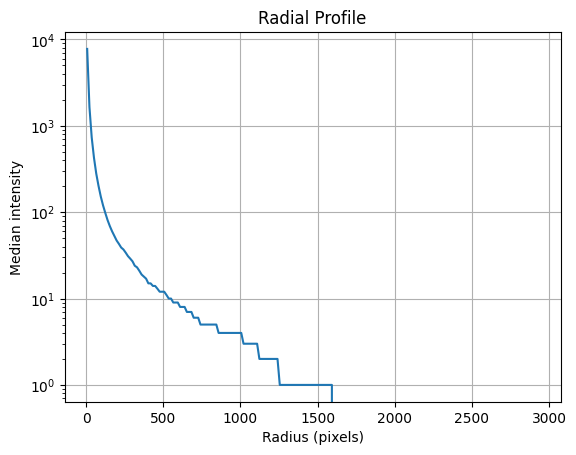

In [5]:
radial_bins, radial_profile_values = radial_profile(img, center=closest_max_pos, bins=200, reduce=np.median)
plt.figure()
plt.plot(radial_bins, radial_profile_values)
plt.yscale('log')
plt.xlabel('Radius (pixels)')
plt.ylabel('Median intensity')
plt.title('Radial Profile')
plt.grid()
plt.show()

/var/folders/l3/lc992wn56dl6hdbnw517rdb80000gn/T/ipykernel_44382/3825739913.py:13: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img - rotational_img), cmap='gray')
/var/folders/l3/lc992wn56dl6hdbnw517rdb80000gn/T/ipykernel_44382/3825739913.py:13: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(img - rotational_img), cmap='gray')


(np.float64(-0.5), np.float64(4095.5), np.float64(4095.5), np.float64(-0.5))

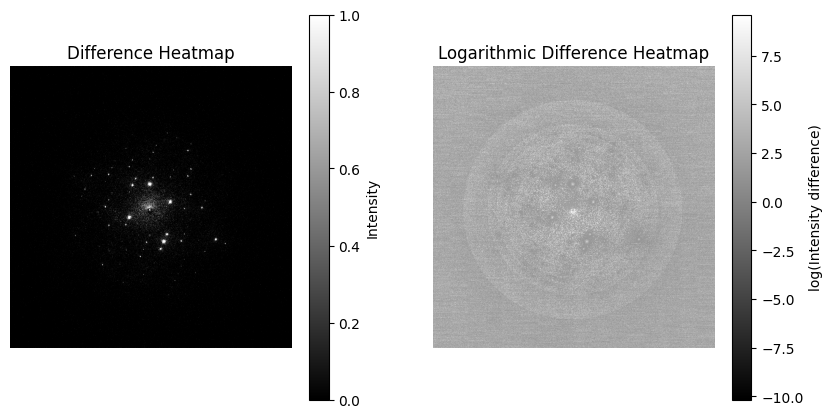

In [19]:
radial_bins, radial_profile_values = radial_profile(img, center=closest_max_pos, bins=200, reduce=np.median)
rotational_img = create_rotational_image_from_profile(radial_bins, radial_profile_values, img.shape, closest_max_pos)

threshold = 20

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow((img - rotational_img) > threshold, cmap='gray')
plt.colorbar(label='Intensity')
plt.title('Difference Heatmap')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.log(img - rotational_img), cmap='gray')
plt.colorbar(label='log(Intensity difference)')
plt.title('Logarithmic Difference Heatmap')
plt.axis('off')

/var/folders/l3/lc992wn56dl6hdbnw517rdb80000gn/T/ipykernel_44382/2747790877.py:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img - rotational_img), cmap='gray')
/var/folders/l3/lc992wn56dl6hdbnw517rdb80000gn/T/ipykernel_44382/2747790877.py:10: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(img - rotational_img), cmap='gray')


(np.float64(-0.5), np.float64(4095.5), np.float64(4095.5), np.float64(-0.5))

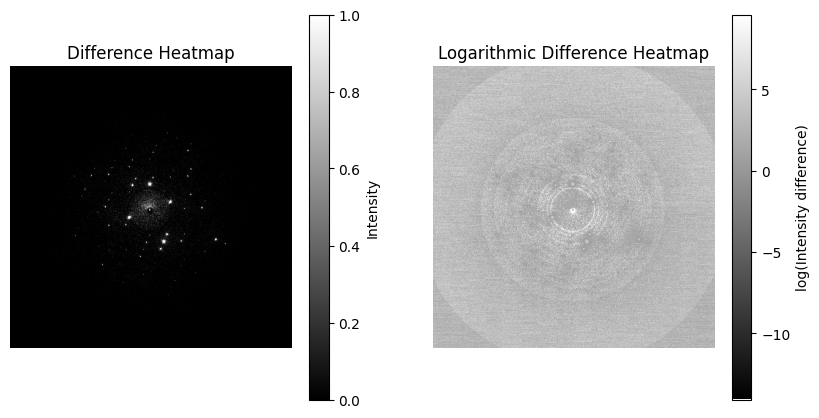

In [20]:
radial_bins, radial_profile_values = radial_profile(img, center=closest_max_pos, bins=200, reduce=np.mean)
rotational_img = create_rotational_image_from_profile(radial_bins, radial_profile_values, img.shape, closest_max_pos)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow((img - rotational_img) > threshold, cmap='gray')
plt.colorbar(label='Intensity')
plt.title('Difference Heatmap')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.log(img - rotational_img), cmap='gray')
plt.colorbar(label='log(Intensity difference)')
plt.title('Logarithmic Difference Heatmap')
plt.axis('off')

(np.float64(-0.5), np.float64(4095.5), np.float64(4095.5), np.float64(-0.5))

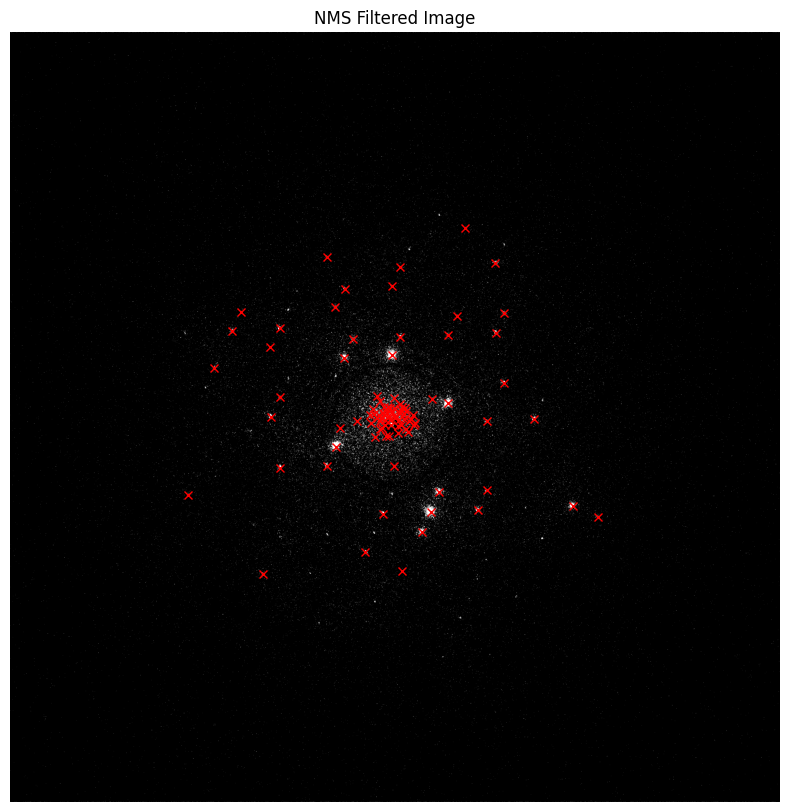

In [22]:
from scipy.ndimage import maximum_filter


def nms_filter(image, size=3, threshold=0):
    """
    Apply Non-Maximum Suppression (NMS) to a 2D image.

    Parameters:
        image : 2D numpy array
            Input image.
        size : int
            Neighborhood size for local maxima (must be odd).
        threshold : float
            Minimum value to consider as a peak.

    Returns:
        nms_mask : 2D boolean numpy array
            Mask of local maxima after NMS.
    """

    # Find local maxima
    local_max = (image == maximum_filter(image, size=size))
    # Apply threshold
    nms_mask = (local_max & (image > threshold)).astype(np.uint8)
    return nms_mask


filtered_img = nms_filter(img - rotational_img, size=20, threshold=100)
peaks_y, peaks_x = np.where(filtered_img)
plt.figure(figsize=(10, 10))
plt.imshow((img - rotational_img) > threshold, cmap='gray')
plt.plot(peaks_x, peaks_y, 'x', color='red')
plt.title('NMS Filtered Image')
plt.axis('off')

(np.float64(-0.5), np.float64(4095.5), np.float64(4095.5), np.float64(-0.5))

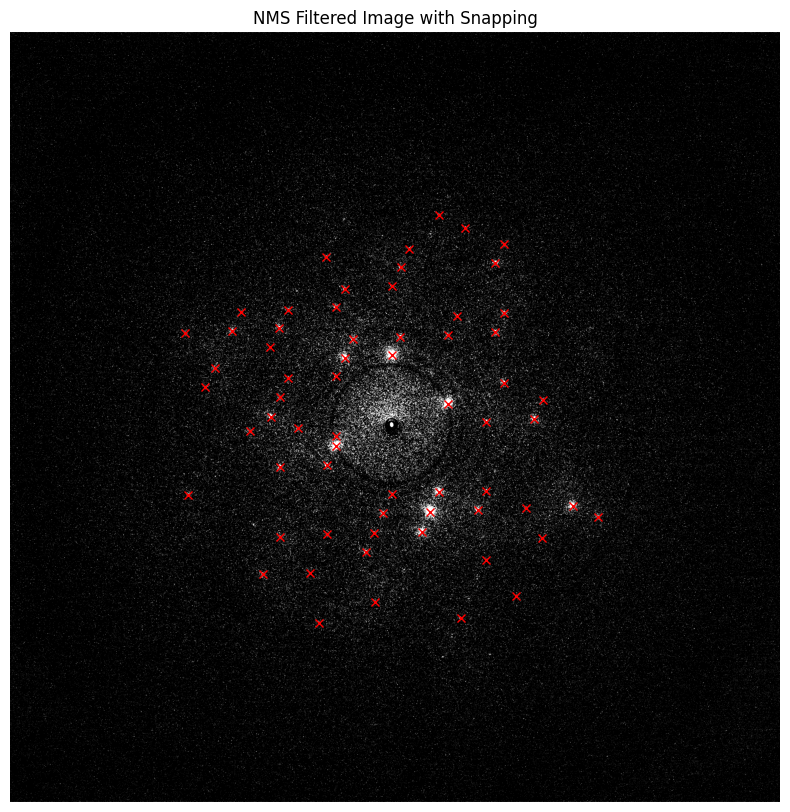

In [66]:
def snap_img_to_rotational(img, rotational_img, closest_max_pos, mode='distance', rad=300, sigma=4):
    """
    Snap the original image to the rotationally symmetric image within a specified radius.

    Parameters:
        img : 2D numpy array
            Original image.
        rotational_img : 2D numpy array
            Rotationally symmetric image.
        closest_max_pos : tuple of floats (x_center, y_center)
            Coordinates of the rotational center.
        rad : int
            Radius around the center to snap.
        sigma : float
            Standard deviation for Gaussian smoothing.

    Returns:
        img_snapping : 2D numpy array
            Image with snapped intensities within the specified radius.
    """
    assert mode in ['distance', 'value'], "Unsupported mode. Use 'distance', 'value'."

    if mode == 'value':
        rotational_img_norm = (rotational_img - rotational_img.min()) / (rotational_img.max() - rotational_img.min())
        indices_y, indices_x = np.where(rotational_img_norm > 0.004)
    elif mode == 'distance':
        indices_y, indices_x = np.indices(img.shape)
        distances = np.sqrt((indices_x - closest_max_pos[0])**2 + (indices_y - closest_max_pos[1])**2)
        mask = distances < rad
        indices_y = indices_y[mask]
        indices_x = indices_x[mask]

    img_snapping = gaussian_filter(img, sigma=sigma).copy()
    img_snapping[indices_y, indices_x] = rotational_img[indices_y, indices_x]

    return img_snapping

img_snapping = snap_img_to_rotational(img, rotational_img, closest_max_pos, mode='distance', rad=300, sigma=4)


filtered_img = nms_filter(img_snapping - rotational_img, size=40, threshold=10)
peaks_y, peaks_x = np.where(filtered_img)

threshold = 10

plt.figure(figsize=(10, 10))
plt.imshow((img - rotational_img) > threshold, cmap='gray')
plt.plot(peaks_x, peaks_y, 'x', color='red')
plt.title('NMS Filtered Image with Snapping')
plt.axis('off')
